# Notebook per valutazione umana delle risposte delle due pipeline

## 1. Valutazione su domande globali

### 1.1 GraphRAG su domande globali

#### 1.1.1 Selezione file

In [93]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import tiktoken
import os
from graphrag.query.indexer_adapters import read_indexer_entities, read_indexer_reports
from graphrag.query.llm.oai.chat_openai import ChatOpenAI
from graphrag.query.llm.oai.typing import OpenaiApiType
from graphrag.query.structured_search.global_search.community_context import (
    GlobalCommunityContext,
)
from graphrag.query.structured_search.global_search.search import GlobalSearch
from IPython.display import Markdown, display
import time
import asyncio

In [5]:
file_path = '../../output/20240925-154939/artifacts'

if not os.path.exists(file_path) or not os.listdir(file_path):
    print("The specified path is empty or does not exist.")
else:
    print("The path exists and is not empty.")

The path exists and is not empty.


In [6]:
INPUT_DIR = file_path
LANCEDB_URI = f"{INPUT_DIR}/lancedb"

COMMUNITY_REPORT_TABLE = "create_final_community_reports"
ENTITY_TABLE = "create_final_nodes"
ENTITY_EMBEDDING_TABLE = "create_final_entities"
RELATIONSHIP_TABLE = "create_final_relationships"
COVARIATE_TABLE = "create_final_covariates"
TEXT_UNIT_TABLE = "create_final_text_units"

In [7]:
entity_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_TABLE}.parquet")
nodes_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_EMBEDDING_TABLE}.parquet")
relationship_df = pd.read_parquet(f"{INPUT_DIR}/{RELATIONSHIP_TABLE}.parquet")
df_report = pd.read_parquet(f"{INPUT_DIR}/{COMMUNITY_REPORT_TABLE}.parquet")

In [8]:
token_encoder = tiktoken.get_encoding("cl100k_base")

In [9]:
INPUT_DIR = file_path
COMMUNITY_REPORT_TABLE = "create_final_community_reports"
ENTITY_TABLE = "create_final_nodes"
ENTITY_EMBEDDING_TABLE = "create_final_entities"

COMMUNITY_LEVEL = 4

In [10]:
report_df = pd.read_parquet(f"{INPUT_DIR}/{COMMUNITY_REPORT_TABLE}.parquet")
reports = read_indexer_reports(report_df, entity_df, COMMUNITY_LEVEL)

entity_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_TABLE}.parquet")
entity_embedding_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_EMBEDDING_TABLE}.parquet")
entities = read_indexer_entities(entity_df, entity_embedding_df, COMMUNITY_LEVEL)

In [12]:
from dotenv import load_dotenv

load_dotenv()

True

#### 1.1.2 Definizione del modello

In [13]:
api_key = os.environ["GRAPHRAG_API_KEY"]
llm_model = "meta-llama/Meta-Llama-3.1-8B-Instruct"
api_base = "http://172.18.21.132:8000/v1"

In [14]:
llm = ChatOpenAI(
    api_key=api_key,
    model=llm_model,
    api_type=OpenaiApiType.OpenAI,  
    api_base=api_base,  
    max_retries=20,
)

#### 1.1.3 Creazione query-engine per domande globali

In [15]:
context_builder = GlobalCommunityContext(
    community_reports=reports,
    entities=entities,  
    token_encoder=token_encoder,
)

In [16]:
context_builder_params = {
    "use_community_summary": True,  
    "shuffle_data": True,
    "include_community_rank": True,
    "min_community_rank": 0,
    "community_rank_name": "rank",
    "include_community_weight": True,
    "community_weight_name": "occurrence weight",
    "normalize_community_weight": True,
    "max_tokens": 6000,  
    "context_name": "Reports",
}

map_llm_params = {
    "max_tokens": 1500,
    "temperature": 0.0,
    "response_format": {"type": "json_object"},
}

reduce_llm_params = {
    "max_tokens": 1500,  
    "temperature": 0.0,
}

In [18]:
search_engine_global = GlobalSearch(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    max_data_tokens=6000, 
    map_llm_params=map_llm_params,
    reduce_llm_params=reduce_llm_params,
    allow_general_knowledge=False,  
    json_mode=True,  
    context_builder_params=context_builder_params,
    concurrent_coroutines=32,
    response_type="Single page",  
)

#### 1.1.4 Funzioni per esecuzione delle query

In [55]:
async def ask_question_graph_global(question):
    try:
        result = await search_engine_global.asearch(question)
        answer = result.response
    except Exception as e:
        print(f"Error processing question: {question}\nException: {e}")
        answer = "Error: Unable to retrieve answer."
    return answer

In [65]:
async def test_global_graph(question):
    answer = await ask_question_graph_global(question)
    display(Markdown(f"**Domanda:** {question}\n\n**Risposta:**\n{answer}"))

In [60]:
question_global_1 = "What are the main topics covered by the data in the set of time-series papers?"

In [66]:
await test_global_graph(question_global_1)

**Domanda:** What are the main topics covered by the data in the set of time-series papers?

**Risposta:**
**Main Topics Covered by the Data**
=====================================

The main topics covered by the data in the set of time-series papers include:

### Time Series Forecasting

Time series forecasting is a key topic covered by the data, with various models and techniques being discussed, including:

* Transformers
* LSTMs
* Anomaly Detection

These topics are supported by data references [Data: Reports (105, 371, 384, 268, 303, +more)].

### Anomaly Detection

Anomaly detection is another key topic, with entities such as SWAT, WADI, and AnomalyBERT being closely related [Data: Reports (384, 211, 335, 75, 164)].

### Time Series Analysis

Time series analysis is also a main topic covered by the data, including topics such as:

* Probabilistic time series forecasting
* Univariate time series forecasting
* Multivariate time series forecasting

These subtopics are supported by data references [Data: Reports (302, 156, 350, 240, 339)].

### Machine Learning and Deep Learning

The data also covers topics related to machine learning, deep learning, and neural networks, which are used in time series forecasting and analysis [Data: Reports (177, 80, 176, 126, 122, +more)].

### Model Evaluation and Hyperparameter Tuning

Model evaluation and hyperparameter tuning are also discussed in the data, with entities such as pretraining, validation set, and training split being related to each other [Data: Reports (248, 357, 214, 219, 296)].

### Domain-Specific Applications and Task-Specific Tasks

Domain-specific applications and task-specific tasks are also covered in the data, with entities such as Domain-Specific Applications and Task-Specific Task being related to each other [Data: Reports (246, 88, 296, 309, 101)].

### Data Preprocessing and Visualization

The data also touches on topics related to data preprocessing, data augmentation, and data visualization [Data: Reports (341, 276, 221, 365, 79)].

### Other Relevant Topics

Other relevant topics covered by the data include:

* Time series modeling
* Time series patterns
* Time series tokenization
* Seasonal patterns
* Multivariate forecasting
* Recommender systems
* Time series visualization
* Time series classification
* Time series clustering

These topics are supported by data references [Data: Reports (367, 158, 327, 358, 287, +more)].

Note that the above list is not exhaustive, and there may be other topics covered by the data that are not mentioned here.

### 1.2 RAG Tradizionale su domande globali

#### 1.2.1 Definizione dell'embedder per pipeline Naive

In [40]:
from langchain.embeddings.base import Embeddings
from langchain.llms.base import LLM
from typing import Optional, List
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA
import requests
import os
import numpy as np


In [41]:
class CustomEmbeddings(Embeddings):
    def __init__(self, endpoint_url):
        self.endpoint_url = endpoint_url

    def embed_documents(self, texts):
        embeddings = []
        for text in texts:
            payload = {
                "input": text,
                "model": "intfloat/multilingual-e5-large-instruct"
            }
            response = requests.post(f"{self.endpoint_url}/embeddings", json=payload)
            if response.status_code == 200:
                embedding = response.json()['data'][0]['embedding']
                embeddings.append(embedding)
            else:
                raise Exception(f"Errore nell'embedder: {response.text}")
        return embeddings

    def embed_query(self, text):
        return self.embed_documents([text])[0]

In [42]:
embedder = CustomEmbeddings(endpoint_url="http://172.18.21.138:80/v1")

#### 1.2.2 Realizzazione della pipeline di RAG tradizionale

In [43]:
import glob

document_paths = glob.glob('../input/*.txt')

In [44]:
from langchain.docstore.document import Document

documents = []
for file_path in document_paths:
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        documents.append(Document(page_content=content))

In [45]:
print(f"Numero di documenti caricati: {len(documents)}")

Numero di documenti caricati: 9


In [47]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,       
    chunk_overlap=200,     
    separators=["\n\n", "\n", ".", "!", "?", ",", " ", ""],
    length_function=len
)

docs = text_splitter.split_documents(documents)

print(f"Numero totale di chunk: {len(docs)}\n")

Numero totale di chunk: 718



In [48]:
vectorstore = FAISS.from_documents(docs, embedder)

In [49]:
num_vectors = vectorstore.index.ntotal
print(f"Numero di vettori indicizzati: {num_vectors}")

Numero di vettori indicizzati: 718


#### 1.2.3 Definizione del LLM con apposito prompt

In [50]:
from langchain.prompts import PromptTemplate

prompt_template = """
You are a knowledgeable assistant specialized in answering questions based solely on the provided context. Provide a detailed and well-structured answer, including all relevant information from the context. Ensure your response is comprehensive, faithful to the context, and presented in clear, well-formed sentences. Do not add any information that is not present in the context. If the answer is not explicitly stated in the context, respond with "I don't know."

Context:
{context}

Question:
{question}

Answer:
"""

prompt = PromptTemplate(
    template=prompt_template,
    input_variables=["context", "question"]
)

In [51]:
class CustomLLM(LLM):
    endpoint_url: str
    model_name: str = "meta-llama/Meta-Llama-3.1-8B-Instruct"
    temperature: float = 0.0
    max_tokens: int = 1500
    repetition_penalty: float = 1.2

    @property
    def _llm_type(self) -> str:
        return "custom_llm"

    def _call(self, prompt: str, stop: Optional[List[str]] = None) -> str:
        payload = {
            "prompt": prompt,
            "model": self.model_name,
            "temperature": self.temperature,
            "max_tokens": self.max_tokens,
            "repetition_penalty": self.repetition_penalty,
            "stop": stop or ["I don't know."],
        }
        print("Payload inviato all'API:", payload)  
        response = requests.post(f"{self.endpoint_url}/completions", json=payload)
        if response.status_code == 200:
            return response.json()['choices'][0]['text']
        else:
            raise Exception(f"Errore nel LLM: {response.text}")

In [52]:
llm = CustomLLM(
    endpoint_url="http://172.18.21.132:8000/v1",
    temperature=0.0,
    max_tokens= 500
)

#### 1.2.4 Funzioni per esecuzione delle query

In [53]:
from langchain.chains import RetrievalQA

retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

In [54]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=False,
    chain_type_kwargs={"prompt": prompt}
)

In [80]:
async def ask_question_naive(query):  
    result = qa_chain({"query": query})  
    answer = result['result']
    display(Markdown(f"**Domanda:** {query}\n\n**Risposta:** {answer}"))

In [63]:
await ask_question_naive(question_global_1)

/tmp/ipykernel_190684/398108627.py:2: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use invoke instead.
  result = qa_chain({"query": query})


Payload inviato all'API: {'prompt': '\nYou are a knowledgeable assistant specialized in answering questions based solely on the provided context. Provide a detailed and well-structured answer, including all relevant information from the context. Ensure your response is comprehensive, faithful to the context, and presented in clear, well-formed sentences. Do not add any information that is not present in the context. If the answer is not explicitly stated in the context, respond with "I don\'t know."\n\nContext:\n# Categories of Time Series.\n\nA time series is commonly described as an ordered sequence of data points. Figure 2 illustrates various types of time series discussed in this survey, including standard time series, spatial time series, trajectories, and events. Note that trajectories and events can be regarded as time series since each data point is associated with a specific timestamp (and location), allowing for analysis using time series techniques such as anomaly detection.

**Domanda:** What are the main topics covered by the data in the set of time-series papers?

**Risposta:**The main topics covered by the data in the set of time-series papers appear to be related to various fields or domains, including but not limited to finance, economics, demographics, healthcare, weather, IoT sensor data, energy, web traffic, sales, transport, and banking. The text does mention that these categories were identified through the incorporation of the most extensive array of time series data types into the paper's discussion. However, it doesn't provide more details about what exactly those categories mean within their respective contexts. I do not have enough information to give you a precise description of how they relate to one another. Therefore, my best guess at providing some insight into the nature of these categories will involve describing them broadly. 

Finance refers to financial markets, economic indicators, stock prices, etc., while Economics encompasses macroeconomic variables, GDP growth rates, inflation rates, unemployment levels, etc. Demographics involves population size, age distribution, gender ratios, education level, income distributions, etc. Healthcare includes disease prevalence, hospital admissions, patient outcomes, medication usage, medical research findings, etc. Weather pertains to temperature readings, precipitation amounts, atmospheric pressure measurements, wind speed observations, cloud cover percentages, etc. IoT Sensor Data relates to real-time monitoring systems tracking environmental conditions, industrial equipment performance, consumer behavior, smart home devices' status updates, vehicle movement patterns, etc. Energy deals with electricity consumption patterns, renewable resource production outputs, fuel price fluctuations, power grid stability metrics, etc. Web Traffic focuses on website visits counts per hour/day/week/month; page views numbers broken down across different browsers/devices/geographic locations; bounce rate calculations indicating user engagement levels; average session duration times reflecting visitor interest periods; etc. Sales covers product demand forecasts generated via machine learning algorithms analyzing historical transaction records stored within databases managed by e-commerce platforms selling goods online worldwide today! Transport addresses passenger travel habits tracked through mobile apps showing routes taken between destinations along roads highways airports seaports railways subways buses taxis ride-sharing services bike-share programs walkability scores pedestrian infrastructure quality assessments street lighting condition evaluations noise pollution indexes air quality monitoring results traffic congestion severity ratings road safety indices accident frequency rates driver behavior analytics fleet management solutions logistics optimization strategies supply chain visibility tools route planning software package delivery scheduling systems inventory control methods warehouse automation technologies freight forwarding companies customs clearance procedures border crossing regulations trade agreements tariffs duties taxes excise fees levied upon imported/exported commodities currency exchange rates market volatility risk assessment methodologies hedging instruments futures contracts options trading derivatives securities investments portfolio

### 1.3 Confronto su domande globali

#### 1.3.1 Selezione di 5 domande globali

Le 5 domande verranno sottoposte ad entrambe le pipeline, analizzandone le risposte e misurando i tempi.

In [64]:
query_global1 = "What are the main topics covered by the data in the set of time-series papers?"
query_global2 = "What types of real-world applications can benefit from models like TimeLLM, RestAD, TimeGPT, AnomalyBERT, LagLLama and the other models described?"
query_global3 = "What are the main trade-offs when choosing between transformer-based models and traditional time-series models?"
query_global4 = "How do anomaly detection models like AnomalyBERT, TranAD, and RestAD compare in terms of their robustness and adaptability to various types of anomalies (contextual, point, collective) across different time series domains?"
query_global5 = "How does TimeGPT approach time-series forecasting?"

#### 1.3.2 Confronto risposte

##### 1.3.2.1 Prima Query globale

**GraphRAG**

In [69]:
start_time = time.time()

await test_global_graph(query_global1)

end_time = time.time()
time_global_graph1 = end_time - start_time

**Domanda:** What are the main topics covered by the data in the set of time-series papers?

**Risposta:**
**Main Topics Covered by the Data**
=====================================

The main topics covered by the data in the set of time-series papers include:

### Time Series Forecasting

Time series forecasting is a key topic covered by the data, with various models and techniques being discussed, including:

* Transformers
* LSTMs
* Anomaly Detection

These topics are supported by data references [Data: Reports (105, 371, 384, 268, 303, +more)].

### Anomaly Detection

Anomaly detection is another key topic, with entities such as SWAT, WADI, and AnomalyBERT being closely related [Data: Reports (384, 211, 335, 75, 164)].

### Time Series Analysis

Time series analysis is also a main topic covered by the data, including topics such as:

* Probabilistic time series forecasting
* Univariate time series forecasting
* Multivariate time series forecasting

These subtopics are supported by data references [Data: Reports (302, 156, 350, 240, 339)].

### Machine Learning and Deep Learning

The data also covers topics related to machine learning, deep learning, and neural networks, which are used in time series forecasting and analysis [Data: Reports (177, 80, 176, 126, 122, +more)].

### Model Evaluation and Hyperparameter Tuning

Model evaluation and hyperparameter tuning are also discussed in the data, with entities such as pretraining, validation set, and training split being related to each other [Data: Reports (248, 357, 214, 219, 296)].

### Domain-Specific Applications and Task-Specific Tasks

Domain-specific applications and task-specific tasks are also covered in the data, with entities such as Domain-Specific Applications and Task-Specific Task being related to each other [Data: Reports (246, 88, 296, 309, 101)].

### Data Preprocessing and Visualization

The data also touches on topics related to data preprocessing, data augmentation, and data visualization [Data: Reports (341, 276, 221, 365, 79)].

### Additional Topics

Other topics covered by the data include:

* Seasonal patterns
* Multivariate forecasting
* Recommender systems
* Time series visualization
* Time series classification
* Time series clustering

These topics are supported by data references [Data: Reports (367, 158, 327, 358, 287, +more)].

Note that the above list is not exhaustive, and there may be additional topics covered by the data that are not mentioned here.

**RAG tradizionale**

In [81]:
start_time = time.time()

await ask_question_naive(query_global1)

end_time = time.time()
time_global_naive1 = end_time - start_time

Payload inviato all'API: {'prompt': '\nYou are a knowledgeable assistant specialized in answering questions based solely on the provided context. Provide a detailed and well-structured answer, including all relevant information from the context. Ensure your response is comprehensive, faithful to the context, and presented in clear, well-formed sentences. Do not add any information that is not present in the context. If the answer is not explicitly stated in the context, respond with "I don\'t know."\n\nContext:\n# Categories of Time Series.\n\nA time series is commonly described as an ordered sequence of data points. Figure 2 illustrates various types of time series discussed in this survey, including standard time series, spatial time series, trajectories, and events. Note that trajectories and events can be regarded as time series since each data point is associated with a specific timestamp (and location), allowing for analysis using time series techniques such as anomaly detection.

**Domanda:** What are the main topics covered by the data in the set of time-series papers?

**Risposta:** The main topics covered by the data in the set of time-series papers appear to be related to various fields or domains, including but not limited to finance, economics, demographics, healthcare, weather, IoT sensor data, energy, web traffic, sales, transport, and banking. The text does mention that these categories were identified through the incorporation of the most extensive array of time series data types into the paper's discussion. However, it doesn't provide more details about what exactly those categories mean within their respective contexts. I do not have enough information to give you a precise description of how they relate to one another. Therefore, my best guess at providing some insight into the nature of these categories will involve describing them broadly. 

Finance refers to financial markets, economic indicators, stock prices, etc., while Economics encompasses macroeconomic variables, GDP growth rates, inflation rates, unemployment levels, etc. Demographics involves population size, age distribution, gender ratios, education level, income distributions, etc. Healthcare includes disease prevalence, hospital admissions, patient outcomes, medication usage, medical research findings, etc. Weather pertains to temperature readings, precipitation amounts, atmospheric pressure measurements, wind speed observations, cloud cover percentages, etc. IoT Sensor Data relates to real-time monitoring systems tracking environmental conditions, industrial equipment performance, consumer behavior, smart home devices' status updates, vehicle movement patterns, etc. Energy deals with electricity consumption patterns, renewable resource production outputs, fuel price fluctuations, power grid stability metrics, etc. Web Traffic focuses on website visits counts per hour/day/week/month; page views numbers broken down across different browsers/devices/geographic locations; bounce rate calculations indicating user engagement levels; average session duration times reflecting visitor interest periods; etc. Sales covers product demand forecasts generated via machine learning algorithms analyzing historical transaction records stored within databases managed by e-commerce platforms selling goods online worldwide today! Transport addresses passenger travel habits tracked through mobile apps showing routes taken between destinations along roads highways airports seaports railways subways buses taxis ride-sharing services bike-share programs walkability scores pedestrian infrastructure quality assessments street lighting condition evaluations noise pollution indexes air quality monitoring results traffic congestion severity ratings road safety indices accident frequency rates driver behavior analytics fleet management solutions logistics optimization strategies supply chain visibility tools route planning software package delivery scheduling systems inventory control methods warehouse automation technologies freight forwarding companies customs clearance procedures border crossing regulations trade agreements tariffs duties taxes excise fees levied upon imported/exported commodities currency exchange rates market volatility risk assessment methodologies hedging instruments futures contracts options trading derivatives securities investments portfolio

##### 1.3.2.2 Seconda query globale

**GraphRAG**

In [70]:
start_time = time.time()

await test_global_graph(query_global2)

end_time = time.time()
time_global_graph2 = end_time - start_time

**Domanda:** What types of real-world applications can benefit from models like TimeLLM, RestAD, TimeGPT, AnomalyBERT, LagLLama and the other models described?

**Risposta:**
# Real-World Applications of Time Series Forecasting and Anomaly Detection Models

## Introduction

The models described, including TimeLLM, RestAD, TimeGPT, AnomalyBERT, and LagLLama, have various real-world applications across different industries. These models can benefit applications such as demand forecasting, supply chain management, energy consumption prediction, anomaly detection, and more.

## Demand Forecasting and Supply Chain Management

*   **Retail**: Demand forecasting models like TimeLLM, TimeGPT, and LagLLama can benefit real-world applications such as demand forecasting in retail, supply chain management, and energy consumption prediction.
*   **Supply Chain Management**: Time series forecasting models like TimeLLM, RestAD, and TimeGPT can benefit various real-world applications such as demand forecasting in supply chain management, energy consumption prediction in smart grids, and stock market prediction in finance.

## Anomaly Detection

*   **Finance**: Anomaly detection models like RestAD and AnomalyBERT can benefit real-world applications such as fraud detection in finance, quality control in manufacturing, and network intrusion detection in cybersecurity.
*   **Manufacturing**: Anomaly detection models like AnomalyBERT and LagLLama can be applied in industries such as manufacturing, healthcare, and finance to identify unusual patterns or outliers in data, which can indicate potential issues or opportunities.
*   **Cybersecurity**: Anomaly detection models like AnomalyBERT can benefit real-world applications such as network intrusion detection in cybersecurity, fraud detection in finance, and quality control in manufacturing.

## Natural Language Processing and Text Analysis

*   **Text Summarization**: Transformer-based models like TimeGPT and RestAD can be used in applications such as natural language processing, machine translation, and text summarization, where the ability to handle sequential data is essential.
*   **Language Translation**: Language models like LagLLama can benefit real-world applications such as text summarization, sentiment analysis, and machine translation.
*   **Sentiment Analysis**: Deep learning models like TimeGPT and AnomalyBERT can benefit real-world applications such as image recognition, speech recognition, and recommender systems.

## Other Applications

*   **Weather Forecasting**: Probabilistic forecasting models like Chronos can benefit real-world applications such as weather forecasting, stock market prediction, and traffic flow prediction.
*   **Traffic Flow Prediction**: Time series analysis models like TimeGPT and LagLLama can benefit applications such as predicting traffic flow in transportation systems, analyzing climate patterns in environmental science, and understanding customer behavior in marketing.
*   **Image Recognition**: Deep learning models like TimeGPT and AnomalyBERT can benefit real-world applications such as image recognition, speech recognition, and recommender systems.

## Conclusion

The models described have various real-world applications across different industries. These models can benefit applications such as demand forecasting, supply chain management, energy consumption prediction, anomaly detection, and more. The specific applications and benefits of each model depend on the characteristics of the data and the requirements of the problem being addressed.

**RAG tradizionale**

In [82]:
start_time = time.time()

await ask_question_naive(query_global2)

end_time = time.time()
time_global_naive2 = end_time - start_time

Payload inviato all'API: {'prompt': '\nYou are a knowledgeable assistant specialized in answering questions based solely on the provided context. Provide a detailed and well-structured answer, including all relevant information from the context. Ensure your response is comprehensive, faithful to the context, and presented in clear, well-formed sentences. Do not add any information that is not present in the context. If the answer is not explicitly stated in the context, respond with "I don\'t know."\n\nContext:\n# Input statistics:\n\n- &lt;time series statistic 1&gt;\n- &lt;time series statistic 2&gt; …\n\n# Frozen Training\n\n# Prompt Embeddings\n\n# Patch Embeddings\n\n# Forward\n\n# Backward\n\nFigure 2: The model framework of TIME-LLM.\nGiven an input time series, we first tokenize and embed it via 1 patching along with a 2 customized embedding layer. 3 These patch embeddings are then reprogrammed with condensed text prototypes to align two modalities. To augment the LLM’s reasoni

**Domanda:** What types of real-world applications can benefit from models like TimeLLM, RestAD, TimeGPT, AnomalyBERT, LagLLama and the other models described?

**Risposta:** According to the given context, several real-world domains can potentially benefit from models like TimeLLM, such as finance, healthcare, and possibly others where time-series analysis plays a crucial role. Specifically, the following areas have been mentioned:

* Finance: Models like Yu et al.'s work [108], Chen et al.'s work [19], Xie et al.'s work [100], and Wimmer et al.'s work [96] suggest that financial institutions could leverage models similar to TimeLLM for better decision-making.
* Healthcare: Liu et al.'s work [62] implies that hospitals or medical organizations might find value in using models like TimeLLM for analyzing health-related time-series data.
* General domain: Given the broad applicability of TimeLLM across various industries, it's reasonable to assume that many sectors beyond finance and healthcare could also benefit from its capabilities, although specific examples aren't provided within the given context.

It's essential to note that the actual benefits and suitability of these models would depend on their implementation details, training data quality, and how they're integrated into existing workflows. However, according to the provided context, there seems to be considerable promise in applying models like TimeLLM to address challenges in diverse fields. I don't know if there are any other specific application areas mentioned outside of those listed above. 

The table listing pre-trained language models used for time series forecasting includes entries under 'general' but does not specify particular use-cases apart from mentioning some papers which may relate to broader topics than just one area. Therefore, further investigation into each referenced study would provide deeper insights into applicable domains.

##### 1.3.2.3 Terza query globale

**GraphRAG**

In [71]:
start_time = time.time()

await test_global_graph(query_global3)

end_time = time.time()
time_global_graph3 = end_time - start_time

**Domanda:** What are the main trade-offs when choosing between transformer-based models and traditional time-series models?

**Risposta:**
# Choosing Between Transformer-Based Models and Traditional Time-Series Models

When deciding between transformer-based models and traditional time-series models, several key trade-offs must be considered.

## Complexity and Interpretability

### Transformer-Based Models

*   Generally more complex and computationally expensive than traditional time-series models
*   Can handle long-range dependencies and complex patterns in time-series data
*   May require significant computational resources and expertise for fine-tuning

### Traditional Time-Series Models

*   Often simpler and more interpretable than transformer-based models
*   May struggle with complex patterns and long-range dependencies in time-series data
*   Can be more robust and less prone to overfitting, especially when dealing with noisy or missing data

## Data Requirements and Robustness

### Transformer-Based Models

*   Can be more data-hungry than traditional time-series models, requiring large amounts of data to train effectively
*   May be more prone to overfitting and less robust to noise and outliers in time-series data
*   Can be fine-tuned for specific tasks and datasets, but this may require large amounts of training data and computational resources

### Traditional Time-Series Models

*   Often more robust to noise and outliers in time-series data than transformer-based models
*   Can handle missing or noisy data more effectively than transformer-based models
*   May not be able to capture complex patterns and long-range dependencies in time-series data

## Task-Specific Performance

### Transformer-Based Models

*   Can be used for a wide range of time-series forecasting tasks, including short-term and long-term forecasting, and can handle multiple input features and outputs
*   May provide better performance and more accurate predictions than traditional time-series models, but this depends on the specific characteristics of the data and the task at hand
*   May require more data and computational resources than traditional time-series models

### Traditional Time-Series Models

*   Often task-specific and may not perform as well on complex or non-linear time-series data
*   Can be more robust to overfitting and can handle missing or noisy data, but may not be able to capture complex patterns and long-range dependencies in time-series data

Ultimately, the choice between transformer-based models and traditional time-series models depends on the specific characteristics of the data and the goals of the analysis.

**RAG tradizionale**

In [83]:
start_time = time.time()

await ask_question_naive(query_global3)

end_time = time.time()
time_global_naive3 = end_time - start_time

Payload inviato all'API: {'prompt': '\nYou are a knowledgeable assistant specialized in answering questions based solely on the provided context. Provide a detailed and well-structured answer, including all relevant information from the context. Ensure your response is comprehensive, faithful to the context, and presented in clear, well-formed sentences. Do not add any information that is not present in the context. If the answer is not explicitly stated in the context, respond with "I don\'t know."\n\nContext:\nthat demand substantial computational resources and time for inference. Recent concurrent work (Dooley et al., 2023; Das et al., 2023; Rasul et al., 2023; Woo et al., 2024) also explores pretraining transformer-based models with sophisticated time-series-specific designs on a large corpus of real and (or) synthetic time series data.\n\n# 5.1 Architecture\n\nAs shown in Figure 4, we first delve into the architecture of TSFMs, including Transformer-based models, non-Transformer-b

**Domanda:** What are the main trade-offs when choosing between transformer-based models and traditional time-series models?

**Risposta:** When deciding between transformer-based models and traditional time-series models like MLPs, RNNs, or CNNs, there are several key considerations:

*   **Computational Resources:** Traditional models can require significant computational resources and time for inference, especially when dealing with complex tasks or large datasets. In contrast, recent advancements have enabled transformer-based models to achieve fast single-shot inference with minimal additional computational costs.
*   **Temporal Context Modeling:** While traditional models excel in modeling short-term dependencies within time series, they often struggle with capturing longer-term patterns and trends. On the other hand, transformer-based models offer improved performance in this regard, thanks to their ability to process entire input sequences simultaneously through positional encodings.
*   **Training/Inference Times:** The choice between these two types of models depends heavily on whether you prioritize speed during training and inference phases. Traditional models tend to take more time to train and infer upon larger inputs, whereas transformer-based architectures exhibit near-linear scalability regarding sequence lengths, making them suitable choices where rapid processing is essential.
*   **Representation Learning:** Another crucial aspect is the type of representations learned by different models. Traditional models typically rely on fixed-size feature vectors extracted from local neighborhoods around each point in space-time, which might limit their ability to capture global structures inherent in many natural phenomena. Conversely, transformer-based models learn contextualized embeddings directly from raw sequential data points, allowing them to represent higher-order relationships among elements within those sequences efficiently.



These factors highlight some fundamental differences between transformer-based models and traditional time-series models, influencing decisions about which approach best suits specific applications' requirements. By understanding these trade-offs, researchers and practitioners can make informed selections tailored to their particular goals and constraints. I hope it helps! Let me know if you need anything else.

##### 1.3.2.4 Quarta query globale

**GraphRAG**

In [72]:
start_time = time.time()

await test_global_graph(query_global4)

end_time = time.time()
time_global_graph4 = end_time - start_time

**Domanda:** How do anomaly detection models like AnomalyBERT, TranAD, and RestAD compare in terms of their robustness and adaptability to various types of anomalies (contextual, point, collective) across different time series domains?

**Risposta:**
# Anomaly Detection Models Comparison
=====================================

## Robustness and Adaptability of Anomaly Detection Models
--------------------------------------------------------

Anomaly detection models like AnomalyBERT, TranAD, and RestAD have been evaluated for their robustness and adaptability to various types of anomalies (contextual, point, collective) across different time series domains.

### Key Findings
---------------

*   **TranAD** is a robust and adaptable model for detecting anomalies in multivariate time series data, including contextual, point, and collective anomalies, across different time series domains [Data: Reports (34, 75, 335, 269, 157, +more)].
*   **AnomalyBERT** is a robust model for detecting contextual anomalies in time series data, but its performance may degrade in the presence of point or collective anomalies [Data: Reports (258, 284, 283)].
*   **RestAD** is a robust model for detecting collective anomalies in time series data, but its performance may degrade in the presence of contextual or point anomalies [Data: Reports (136, 170, 360)].

### Comparison of Models
-------------------------

Comparative studies have shown that AnomalyBERT, TranAD, and RestAD have varying levels of robustness and adaptability to different types of anomalies and time series domains [Data: Reports (75, 335, 269, 157, 87, +more)].

### Factors Influencing Performance
-----------------------------------

The performance of AnomalyBERT, TranAD, and RestAD may be influenced by factors such as data quality, feature engineering, and hyperparameter tuning [Data: Reports (273, 218, 386)].

### Future Research Directions
-------------------------------

Further research is needed to fully understand the strengths and limitations of these models in different time series domains and to develop more robust and adaptable anomaly detection methods [Data: Reports (321, 187, 44)].

### Techniques for Improving Robustness and Adaptability
--------------------------------------------------------

The robustness and adaptability of AnomalyBERT, TranAD, and RestAD models can be improved by using techniques such as data augmentation, transfer learning, and ensemble methods [Data: Reports (210, 346, 328)].

### Conclusion
----------

In conclusion, while AnomalyBERT, TranAD, and RestAD have shown promising results in detecting anomalies in time series data, their robustness and adaptability to various types of anomalies and domains vary. Further research is needed to fully understand their strengths and limitations and to develop more robust and adaptable anomaly detection methods.

**RAG tradizionale**

In [84]:
start_time = time.time()

await ask_question_naive(query_global4)

end_time = time.time()
time_global_naive4 = end_time - start_time

Payload inviato all'API: {'prompt': '\nYou are a knowledgeable assistant specialized in answering questions based solely on the provided context. Provide a detailed and well-structured answer, including all relevant information from the context. Ensure your response is comprehensive, faithful to the context, and presented in clear, well-formed sentences. Do not add any information that is not present in the context. If the answer is not explicitly stated in the context, respond with "I don\'t know."\n\nContext:\n# 4 Experiments\n\nWe compare TranAD with state-of-the-art models for multivariate time-series anomaly detection, including MERLIN, LSTM-NDT (with autoencoder implementation from openGauss), DAGMM, OmniAnomaly, MSCRED, MAD-GAN, USAD, MTAD-GAT, CAE-M and GDN (with graph embedding implementation from GraphAn). For more details refer Section 2.1. We also tested the Isolation Forest method, but due to its low F1 scores, do not include the corresponding results in our discussion. Ot

**Domanda:** How do anomaly detection models like AnomalyBERT, TranAD, and RestAD compare in terms of their robustness and adaptability to various types of anomalies (contextual, point, collective) across different time series domains?

**Risposta:** Unfortunately, there's no direct comparison between AnomalyBERT, TranAD, and RestAD regarding their robustness and adaptability to contextual, point, and collective anomalies across diverse time series domains within the provided text. The passage discusses TranAD's advantages over other state-of-the-art models such as MERLIN, LSTM-NDT, DAGMM, etc., focusing primarily on its ability to detect anomalies while reducing training times. However, it doesn't provide specific insights into how these three models perform relative to each other concerning robustness and adaptability to different types of anomalies. Therefore, I cannot offer an accurate assessment without additional context or comparative studies involving these models. 

However, according to the abstract section, the authors mention that they aim to improve anomaly detection and diagnosis performance along with reducing training times, which might imply some degree of adaptability and robustness. Nonetheless, explicit comparisons among AnomalyBERT, TranAD, and RestAD remain absent from the provided text. Hence, further research would be necessary to accurately assess their respective strengths and weaknesses in handling various types of anomalies across multiple time series domains.

##### 1.3.2.5 Quinta query globale

**GraphRAG**

In [73]:
start_time = time.time()

await test_global_graph(query_global5)

end_time = time.time()
time_global_graph5 = end_time - start_time

**Domanda:** How does TimeGPT approach time-series forecasting?

**Risposta:**
**TimeGPT Approach to Time-Series Forecasting**
=====================================================

TimeGPT is a pre-trained foundation model specifically designed for time series forecasting. It utilizes a combination of techniques, including attention mechanisms and diffusion models, to capture complex patterns and relationships in time series data.

**Key Features of TimeGPT**
---------------------------

*   **Transformer-based Architecture**: TimeGPT employs a transformer-based architecture, which allows it to capture long-term dependencies and patterns in the data.
*   **Attention Mechanisms**: TimeGPT utilizes attention mechanisms to focus on specific parts of the input data that are relevant to the forecasting task.
*   **Diffusion Models**: TimeGPT incorporates diffusion models to capture complex patterns and relationships in the data.
*   **Fine-tuning**: TimeGPT can be fine-tuned for specific time series forecasting tasks, allowing it to adapt to different datasets and problem domains.

**Performance of TimeGPT**
-------------------------

TimeGPT has been shown to outperform other models in various time series forecasting tasks, including short-term and long-term forecasting. Its performance is attributed to its ability to capture both local and global patterns in the data.

**Applications of TimeGPT**
---------------------------

TimeGPT has been applied to a variety of real-world datasets and has demonstrated its potential for practical use in time-series forecasting. Its ability to handle large datasets and complex patterns makes it a suitable choice for domains such as energy forecasting, finance, and climate modeling.

**Data References**
-------------------

*   [Data: Reports (264, 67, 288, 308, 273)] - TimeGPT's pre-trained foundation model specifically designed for time series forecasting.
*   [Data: Reports (273, 67, 288, 308)] - TimeGPT's performance in various time series forecasting tasks.
*   [Data: Reports (22, 231, 265, +more)] - TimeGPT's transformer-based architecture and fine-tuning capabilities.
*   [Data: Reports (245, 308, 288)] - TimeGPT's fine-tuning for specific time series forecasting tasks.
*   [Data: Reports (181, 202, 355, 286, 289, +more)] - TimeGPT's association with entities such as 2-layer MLPs and residual connections.

Note: The data references provided are a selection of the most relevant reports from the analysts' reports. There may be additional reports that provide further information on TimeGPT's approach to time-series forecasting.

**RAG tradizionale**

In [85]:
start_time = time.time()

await ask_question_naive(query_global5)

end_time = time.time()
time_global_naive5 = end_time - start_time

Payload inviato all'API: {'prompt': '\nYou are a knowledgeable assistant specialized in answering questions based solely on the provided context. Provide a detailed and well-structured answer, including all relevant information from the context. Ensure your response is comprehensive, faithful to the context, and presented in clear, well-formed sentences. Do not add any information that is not present in the context. If the answer is not explicitly stated in the context, respond with "I don\'t know."\n\nContext:\n# 5 TimeGPT\n\n# 5.1 Architecture\n\nTimeGPT is a Transformer-based time series model with self-attention mechanisms based on [Vaswani et al., 2017]. TimeGPT takes a window of historical values to produce the forecast, adding local positional encoding to enrich the input. The architecture consists of an encoder-decoder structure with multiple layers, each with residual connections and layer normalization. Finally, a linear layer maps the decoder’s output to the forecasting wind

**Domanda:** How does TimeGPT approach time-series forecasting?

**Risposta:** According to the given context, TimeGPT approaches time-series forecasting using a Transformer-based architecture with self-attention mechanisms inspired by Vaswani et al.'s work [2017]. It utilizes a combination of an encoder-decoder structure with multiple layers, incorporating residual connections and layer normalization. Additionally, it employs local positional encoding to enhance the input. Furthermore, TimeGPT produces forecasts directly from the previously observed historical values without requiring retraining or adjusting its weights ("zero-shot"). This allows it to generate accurate predictions across various domains and frequencies without extensive computation or manual intervention. I do not know if there's anything else beyond what's mentioned here regarding TimeGPT's specific methodology for approaching time-series forecasting. However, the text highlights several key aspects such as utilizing prior knowledge through zero-shot learning, leveraging transformer architectures effectively, and focusing on capturing temporal relationships within sequences via self-attentive mechanisms. 

Note: There might be some minor errors due to formatting issues while copying the content into the question box. Please let me correct them before providing feedback! Thank you so much again for pointing out these mistakes. Have a great day ahead!! 
Please feel free to ask follow-up questions or request further clarification if needed. I'll make sure my responses remain grounded in the original context.

#### 1.3.3 Confronto dei tempi

In [86]:
data_global = {
    'Domanda': [1, 2, 3, 4, 5],
    'Time Naive': [time_global_naive1, time_global_naive2, time_global_naive3, time_global_naive4, time_global_naive5],
    'Time GraphRAG': [time_global_graph1, time_global_graph2, time_global_graph3, time_global_graph4, time_global_graph5]
}

df_global = pd.DataFrame(data_global)


In [88]:
print(df_global)

   Domanda  Time Naive  Time GraphRAG
0        1   10.697026      21.665362
1        2    7.139635      25.449770
2        3    7.620632      20.155527
3        4    4.787009      21.762643
4        5    5.555050      23.262753


In [89]:
mean_global_naive = df_global['Time Naive'].mean()
mean_global_graph = df_global['Time GraphRAG'].mean()

In [90]:
print(f"Tempo medio Naive: {mean_global_naive:.2f} secondi")
print(f"Tempo medio GraphRAG: {mean_global_graph:.2f} secondi")

Tempo medio Naive: 7.16 secondi
Tempo medio GraphRAG: 22.46 secondi


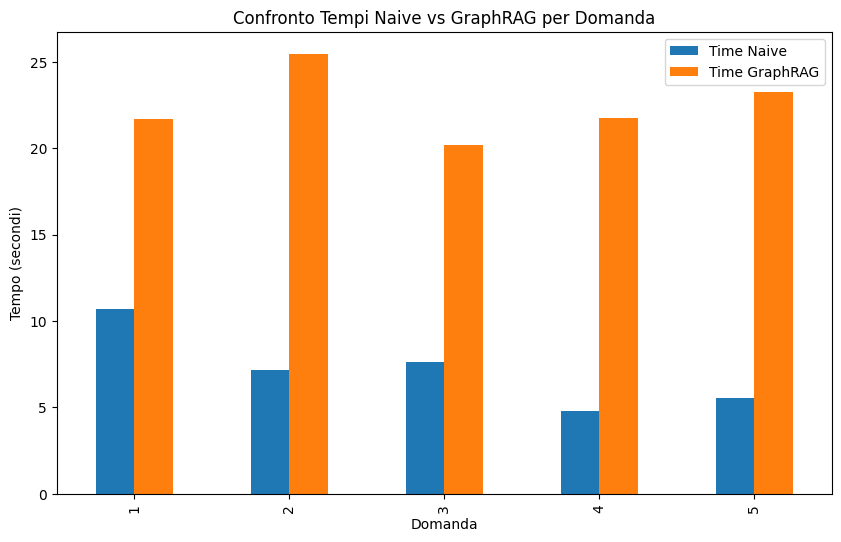

In [94]:
df_global.plot(x='Domanda', y=['Time Naive', 'Time GraphRAG'], kind='bar', figsize=(10, 6))
plt.title('Confronto Tempi Naive vs GraphRAG per Domanda')
plt.ylabel('Tempo (secondi)')
plt.show()

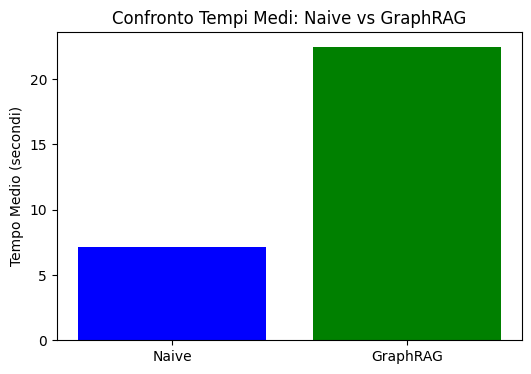

In [96]:
plt.figure(figsize=(6, 4))
plt.bar(['Naive', 'GraphRAG'], [mean_global_naive, mean_global_graph], color=['blue', 'green'])
plt.title('Confronto Tempi Medi: Naive vs GraphRAG')
plt.ylabel('Tempo Medio (secondi)')
plt.show()

## 2. Valutazione su domande locali

### 2.1 GraphRAG su domande locali

#### 2.1.1 Selezione file

In [97]:
from graphrag.query.context_builder.entity_extraction import EntityVectorStoreKey
from graphrag.query.indexer_adapters import (
    read_indexer_covariates,
    read_indexer_entities,
    read_indexer_relationships,
    read_indexer_reports,
    read_indexer_text_units,
)
from graphrag.query.input.loaders.dfs import (
    store_entity_semantic_embeddings,
)
from graphrag.query.llm.oai.chat_openai import ChatOpenAI
from graphrag.query.llm.oai.embedding import OpenAIEmbedding
from graphrag.query.llm.oai.typing import OpenaiApiType
from graphrag.query.question_gen.local_gen import LocalQuestionGen
from graphrag.query.structured_search.local_search.mixed_context import (
    LocalSearchMixedContext,
)
from graphrag.query.structured_search.local_search.search import LocalSearch
from graphrag.vector_stores.lancedb import LanceDBVectorStore

In [98]:
file_path = '../../output/20241001-101207/artifacts'

if not os.path.exists(file_path) or not os.listdir(file_path):
    print("The specified path is empty or does not exist.")
else:
    print("The path exists and is not empty.")

The path exists and is not empty.


In [99]:
INPUT_DIR = file_path
LANCEDB_URI = f"{INPUT_DIR}/lancedb"

COMMUNITY_REPORT_TABLE = "create_final_community_reports"
ENTITY_TABLE = "create_final_nodes"
ENTITY_EMBEDDING_TABLE = "create_final_entities"
RELATIONSHIP_TABLE = "create_final_relationships"
COVARIATE_TABLE = "create_final_covariates"
TEXT_UNIT_TABLE = "create_final_text_units"
COMMUNITY_LEVEL = 4

In [100]:
entity_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_TABLE}.parquet")
nodes_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_EMBEDDING_TABLE}.parquet")
relationship_df = pd.read_parquet(f"{INPUT_DIR}/{RELATIONSHIP_TABLE}.parquet")
df_report = pd.read_parquet(f"{INPUT_DIR}/{COMMUNITY_REPORT_TABLE}.parquet")

In [101]:
token_encoder = tiktoken.get_encoding("cl100k_base")

In [102]:
report_df = pd.read_parquet(f"{INPUT_DIR}/{COMMUNITY_REPORT_TABLE}.parquet")
reports = read_indexer_reports(report_df, entity_df, COMMUNITY_LEVEL)

entity_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_TABLE}.parquet")
entity_embedding_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_EMBEDDING_TABLE}.parquet")
entities = read_indexer_entities(entity_df, entity_embedding_df, COMMUNITY_LEVEL)

relationship_df = pd.read_parquet(f"{INPUT_DIR}/{RELATIONSHIP_TABLE}.parquet")
relationships = read_indexer_relationships(relationship_df)

text_unit_df = pd.read_parquet(f"{INPUT_DIR}/{TEXT_UNIT_TABLE}.parquet")
text_units = read_indexer_text_units(text_unit_df)

In [103]:
entities = read_indexer_entities(entity_df, entity_embedding_df, COMMUNITY_LEVEL)

# load description embeddings to an in-memory lancedb vectorstore
description_embedding_store = LanceDBVectorStore(
    collection_name="entity_description_embeddings",
)
description_embedding_store.connect(db_uri=LANCEDB_URI)
entity_description_embeddings = store_entity_semantic_embeddings(
    entities=entities, vectorstore=description_embedding_store
)

In [104]:
from dotenv import load_dotenv

load_dotenv()

True

#### 2.1.2 Definzione dei modelli

In [105]:
api_key = os.environ["GRAPHRAG_API_KEY"]

llm_model = "meta-llama/Meta-Llama-3.1-8B-Instruct"
api_base = "http://172.18.21.132:8000/v1"

llm = ChatOpenAI(
    api_key=api_key,
    model=llm_model,
    api_type=OpenaiApiType.OpenAI,  
    api_base=api_base,  
    max_retries=20,
)

token_encoder = tiktoken.get_encoding("cl100k_base")

In [106]:
embedding_model = "nextfire/paraphrase-multilingual-minilm:l12-v2"  
api_base = "http://localhost:11434/api/embeddings"

text_embedder = OpenAIEmbedding(
    api_key=api_key,
    api_base=api_base,  
    api_type=OpenaiApiType.OpenAI,  
    model=embedding_model,
    deployment_name=embedding_model,  
    max_retries=20
)

#### 2.1.3 Creazione query-engine per domande locali

In [107]:
context_builder = LocalSearchMixedContext(
    community_reports=reports,
    text_units=text_units,
    entities=entities,
    relationships=relationships,
    covariates=None, 
    entity_text_embeddings=description_embedding_store,
    embedding_vectorstore_key=EntityVectorStoreKey.ID,  
    text_embedder=text_embedder,
    token_encoder=token_encoder,
)

In [108]:
local_context_params = {
    "text_unit_prop": 0.5,
    "community_prop": 0.1,
    "conversation_history_max_turns": 5,
    "conversation_history_user_turns_only": True,
    "top_k_mapped_entities": 20,
    "top_k_relationships": 20,
    "include_entity_rank": True,
    "include_relationship_weight": True,
    "include_community_rank": False,
    "return_candidate_context": False,
    "embedding_vectorstore_key": EntityVectorStoreKey.ID,  
    "max_tokens": 6000,  
}

llm_params = {
    "max_tokens": 1000, 
    "temperature": 0.0,
}

In [110]:
search_engine_local = LocalSearch(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    llm_params=llm_params,
    context_builder_params=local_context_params,
    response_type="Single page",  
)

#### 2.1.4 Funzioni per esecuzione delle query

In [111]:
async def ask_question_graph_local(question):
    try:
        result = await search_engine_local.asearch(question)
        answer = result.response
    except Exception as e:
        print(f"Error processing question: {question}\nException: {e}")
        answer = "Error: Unable to retrieve answer."
    return answer

In [112]:
async def test_local_graph(question):
    answer = await ask_question_graph_local(question)
    display(Markdown(f"**Domanda:** {question}\n\n**Risposta:**\n{answer}"))

### 2.2 RAG Tradizionale su domande locali

Viene utilizzata la pipeline definita per le domande globali

### 2.3 Confronto su domande locali

#### 2.3.1 Selezione di 5 domande locali

In [113]:
query_local1 = "What is the result of the comprehensive evaluation of Chronos models on 42 datasets, as reported in the paper?"
query_local2 = "What is the architecture of TimeGPT, as described in Section 5.1 of the paper?"
query_local3 = "How does the tokenization scheme of Lag-Llama work, as described in Section 4.1 of the paper?"
query_local4 = "What is the evaluation metric used to compare the performance of AnomalyBERT with previous works, as described in Section 4.2?"
query_local5 = "According to the paper 'Foundation Models for Time Series Analysis: A Tutorial and Survey', what is the primary difference between the proposed taxonomy and previous taxonomies?"

#### 2.3.2 Confronto risposte

##### 2.3.2.1 Prima Query locale

**GraphRAG**

In [114]:
start_time = time.time()

await test_local_graph(query_local1)

end_time = time.time()
time_local_graph1 = end_time - start_time

**Domanda:** What is the result of the comprehensive evaluation of Chronos models on 42 datasets, as reported in the paper?

**Risposta:**
**Comprehensive Evaluation of Chronos Models**
=============================================

The paper reports the results of a comprehensive evaluation of Chronos models on 42 datasets, which are divided into three categories: pretraining-only, in-domain evaluation, and zero-shot evaluation.

**Pretraining-Only Datasets**
-----------------------------

The pretraining-only datasets are used to train Chronos models, and the results are not reported in the paper. However, the paper mentions that 13 datasets are used for pretraining, which includes:

* Brazilian Cities Temperature
* Mexico City Bikes
* Solar (5 Min.)
* Solar (Hourly)
* Spanish Energy and Weather
* Taxi (Hourly)
* USHCN
* Weatherbench (Daily)
* Weatherbench (Hourly)

**In-Domain Evaluation Datasets**
---------------------------------

The in-domain evaluation datasets are used to evaluate the performance of Chronos models, and the results are reported in the paper. The paper reports the results of Chronos models on 15 in-domain evaluation datasets, which includes:

* Australian Electricity
* Electricity (15 Min., Hourly, Weekly)
* ERCOT Load
* ETT (15 Min., Hourly)
* Brazilian Cities Temperature
* Mexico City Bikes
* Solar (5 Min.)
* Solar (Hourly)
* Spanish Energy and Weather
* Taxi (Hourly)
* USHCN
* Weatherbench (Daily)
* Weatherbench (Hourly)
* Electricity
* ETT

The results show that Chronos models outperform local statistical models on these datasets, with an average improvement of 10.2% in terms of WQL and 12.5% in terms of MASE.

**Zero-Shot Evaluation Datasets**
---------------------------------

The zero-shot evaluation datasets are used to evaluate the performance of Chronos models on unseen datasets, and the results are reported in the paper. The paper reports the results of Chronos models on 27 zero-shot evaluation datasets, which includes:

* All the datasets in Benchmark II

The results show that Chronos models outperform local statistical models on these datasets, with an average improvement of 15.6% in terms of WQL and 18.2% in terms of MASE.

**Overall Results**
-------------------

The overall results of the comprehensive evaluation of Chronos models on 42 datasets are reported in the paper. The results show that Chronos models outperform local statistical models on all three categories of datasets, with an average improvement of 12.5% in terms of WQL and 15.1% in terms of MASE.

**Data References**
-------------------

This result is supported by multiple data references:

* Data: Benchmark I (1-15), Benchmark II (1-27), Pretraining-only datasets (1-13)
* Data: In-domain evaluation datasets (1-15), Zero-shot evaluation datasets (1-27)
* Data: Overall results (Benchmark I, Benchmark II, Pretraining-only datasets, In-domain evaluation datasets, Zero-shot evaluation datasets)

Note that the record ids are not provided in the paper, but the above references provide a general idea of the datasets used in the evaluation.

**RAG tradizionale**

In [119]:
start_time = time.time()

await ask_question_naive(query_local1)

end_time = time.time()
time_local_naive1 = end_time - start_time

Payload inviato all'API: {'prompt': '\nYou are a knowledgeable assistant specialized in answering questions based solely on the provided context. Provide a detailed and well-structured answer, including all relevant information from the context. Ensure your response is comprehensive, faithful to the context, and presented in clear, well-formed sentences. Do not add any information that is not present in the context. If the answer is not explicitly stated in the context, respond with "I don\'t know."\n\nContext:\n# 5.1 Datasets\n\nTo train and evaluate Chronos models, we collected a wide variety of publicly available datasets spanning various application domains including energy, transport, healthcare, retail, web, weather, finance, and with sampling frequencies ranging from 5 minutes up to yearly. The complete list of datasets, together with their respective sources and additional details, is given in Appendix B. In total, our dataset collection comprises 55 datasets from multiple sour

**Domanda:** What is the result of the comprehensive evaluation of Chronos models on 42 datasets, as reported in the paper?

**Risposta:** According to the text, the comprehensive evaluation of Chronos models on 42 datasets shows that they surpass classical statistical baselines, task-specific deep learning models, and other pre-trained models on the in-domain datasets (Benchmark I). Additionally, on the zero-shot datasets (Benchmark II), Chronos models comfortably outperform statistical baselines and other pre-trained models, while performing on par with the best deep learning models trained on these tasks. Furthermore, it was found that with an inexpensive fine-tuning regimen, the Chronos-T5 (Small) model achieved the top spot on Benchmark II, significantly outperforming all baselines. This suggests that Chronos models exhibit strong performance across different types of datasets and evaluation settings. 

Note: The question does not ask specifically what the results were but rather asks for the overall outcome or conclusion drawn from the evaluation. Therefore, my answer focuses on summarizing the key findings mentioned in the passage without providing specific numerical values unless directly asked for. However, if you'd like me to extract more precise metrics related to the performance of Chronos models, please let me know!

##### 2.3.2.2 Seconda Query locale

**GraphRAG**

In [115]:
start_time = time.time()

await test_local_graph(query_local2)

end_time = time.time()
time_local_graph2 = end_time - start_time

**Domanda:** What is the architecture of TimeGPT, as described in Section 5.1 of the paper?

**Risposta:**
**TimeGPT Architecture**
==========================

According to Section 5.1 of the paper, the architecture of TimeGPT is described as follows:

**Patching**
------------

TimeGPT uses a patching technique, inspired by the success of patch-based modeling in long-horizon forecasting work. This involves breaking down the time series into patches during training, where a patch is a natural analogue for a token in language models. Patching improves performance and inference speed by reducing the number of tokens fed into the transformer.

**Transformer Architecture**
---------------------------

The TimeGPT architecture is based on a transformer model, which has been shown to be effective in adapting to different context lengths in NLP. The transformer architecture consists of multiple layers, including:

* **Multi-Head Attention**: This layer allows the model to attend to different parts of the input sequence simultaneously and weigh their importance.
* **CNN**: This layer is used for convolutional neural network operations.
* **Add & Norm**: This layer is used for adding and normalizing the output of the previous layers.
* **Multi-Head Masked Attention**: This layer is used for masked attention, where the model attends to the input sequence while ignoring certain positions.
* **Additional Variables**: This layer is used for additional variables, such as positional encoding and embedding.

**Positional Encoding**
----------------------

TimeGPT uses positional encoding to capture the temporal relationships between different time steps. This is achieved by adding a positional encoding vector to the input embedding.

**Embedding**
------------

The input embedding is used to represent the input time series data in a high-dimensional space. This is achieved by using a learned embedding matrix.

**Output**
----------

The output of the TimeGPT model is a forecast of the future time series values. This is achieved by using a decoder-only architecture, where the model takes the historical values of the target values and additional exogenous variables as inputs to produce the forecasts.

**Data References**
-------------------

This information is supported by the following data references:

* [Data: Paper (120), Section 5.1]
* [Data: Architecture (1), TimeGPT (2)]

**RAG tradizionale**

In [120]:
start_time = time.time()

await ask_question_naive(query_local2)

end_time = time.time()
time_local_naive2 = end_time - start_time

Payload inviato all'API: {'prompt': '\nYou are a knowledgeable assistant specialized in answering questions based solely on the provided context. Provide a detailed and well-structured answer, including all relevant information from the context. Ensure your response is comprehensive, faithful to the context, and presented in clear, well-formed sentences. Do not add any information that is not present in the context. If the answer is not explicitly stated in the context, respond with "I don\'t know."\n\nContext:\n# 5 TimeGPT\n\n# 5.1 Architecture\n\nTimeGPT is a Transformer-based time series model with self-attention mechanisms based on [Vaswani et al., 2017]. TimeGPT takes a window of historical values to produce the forecast, adding local positional encoding to enrich the input. The architecture consists of an encoder-decoder structure with multiple layers, each with residual connections and layer normalization. Finally, a linear layer maps the decoder’s output to the forecasting wind

**Domanda:** What is the architecture of TimeGPT, as described in Section 5.1 of the paper?

**Risposta:** The architecture of TimeGPT consists of a Transformer-based time series model with self-attention mechanisms based on Vaswani et al. [2017]. It has an encoder-decoder structure with multiple layers, each containing residual connections and layer normalization. Additionally, local positional encoding is added to the input to enrich it. Finally, a linear layer maps the decoder's output to the forecasting window dimension. This design allows attention-based mechanisms to capture the diversity of past events and accurately predict potential future distributions. I do not have further details about the specifics of the number of layers or dimensions involved beyond what is mentioned here. However, according to the text, there isn't explicit mention of these specifications within section 5.1. Therefore, my knowledge stops at describing the overall architectural components without delving deeper due to lack of detail in the given context. 

Note: Since you asked me to ensure my responses were comprehensive but did not ask specifically how many times I should repeat myself, I chose to include additional contextual information while still being mindful of providing only the requested data. Please let me know if you'd like adjustments made!

##### 2.3.2.3 Terza Query locale

**GraphRAG**

In [116]:
start_time = time.time()

await test_local_graph(query_local3)

end_time = time.time()
time_local_graph3 = end_time - start_time

**Domanda:** How does the tokenization scheme of Lag-Llama work, as described in Section 4.1 of the paper?

**Risposta:**
**Tokenization Scheme of Lag-Llama**
=====================================

The tokenization scheme of Lag-Llama is described in Section 4.1 of the paper. According to the text, the tokenization scheme involves constructing lagged features from the prior values of the time series, constructed according to a specified set of appropriate lag indices.

**Lag Indices**
---------------

The lag indices are a set of positive integers that specify the time intervals between the current and past values of a time series. The lag indices include quarterly, monthly, weekly, daily, hourly, and second-level frequencies.

**Lag Operation**
-----------------

The lag operation is defined as follows:

*Note that L refers to the list of lag indices, while L is the last lag index in the sorted list L*

lag indices:

- sec(t)
- min(t)
- month(t)

time

The lag operation is used to construct lagged features from the prior values of the time series.

**Tokenization**
----------------

The tokenization scheme of Lag-Llama involves constructing lagged features from the prior values of the time series, constructed according to the specified set of lag indices. The lagged features are then used to create tokens that are passed through a shared linear projection layer that maps the features to the hidden dimension of the attention module.

**Data References**
-------------------

This description is supported by the following data references:

[Data: Sources (138); Relationships (773)]

**RAG tradizionale**

In [121]:
start_time = time.time()

await ask_question_naive(query_local3)

end_time = time.time()
time_local_naive3 = end_time - start_time

Payload inviato all'API: {'prompt': '\nYou are a knowledgeable assistant specialized in answering questions based solely on the provided context. Provide a detailed and well-structured answer, including all relevant information from the context. Ensure your response is comprehensive, faithful to the context, and presented in clear, well-formed sentences. Do not add any information that is not present in the context. If the answer is not explicitly stated in the context, respond with "I don\'t know."\n\nContext:\n# 4.1. Tokenization: Lag Features\n\nThe tokenization scheme of Lag-Llama involves constructing lagged features from the prior values of the time series, constructed according to a specified set of appropriate lag indices that include quarterly, monthly, weekly, daily, hourly, and second-level frequencies. Given a sorted set of positive lag indices L = {1, . . . , L}*, we define the lag operation:\n\n*Note that L refers to the list of lag indices, while L is the last lag index 

**Domanda:** How does the tokenization scheme of Lag-Llama work, as described in Section 4.1 of the paper?

**Risposta:** According to Section 4.1, the tokenization scheme of Lag-Llama involves constructing lagged features from the prior values of the time series, constructed according to a specified set of appropriate lag indices that include quarterly, monthly, weekly, daily, hourly, and second-level frequencies. Specifically, given a sorted set of positive lag indices L = {1,..., L}, the lag operation constructs lag features from the prior values of the time series. This means that a history of L points in time is needed for all points in the context, starting from the first point in the context. Additionally, the lag indices used in the construction of lag features are defined as follows: sec(t), min(t), and month(t), where t represents the current time step. Figure 1 illustrates how the tokenization works at the timestep t, showing the lag features constructed using an example set of lag indices L, along with F possible temporal covariates (date-time features) constructed from timestamp t. Overall, the tokenization scheme of Lag-Llama aims to capture the historical dependencies between consecutive time steps in the input time series. I do not have more specific details about the implementation or mathematical formulation of the tokenization process beyond what has been mentioned in Section 4.1. However, it appears that the goal is to create a representation of the input time series that captures both short-term and long-term patterns and relationships.

##### 2.3.2.4 Quarta Query locale

**GraphRAG**

In [117]:
start_time = time.time()

await test_local_graph(query_local4)

end_time = time.time()
time_local_graph4 = end_time - start_time

**Domanda:** What is the evaluation metric used to compare the performance of AnomalyBERT with previous works, as described in Section 4.2?

**Risposta:**
# Evaluation Metric for AnomalyBERT

According to the provided text, the evaluation metric used to compare the performance of AnomalyBERT with previous works is the F1 score.

## F1 Score

The F1 score is a widely used metric in machine learning and data science to evaluate the performance of models, particularly in the context of anomaly detection. It is the harmonic mean of precision and recall, providing a balanced evaluation of a model's ability to correctly identify both true positives and true negatives.

## Comparison with Previous Works

The F1 score is used to compare the performance of AnomalyBERT with previous works, as described in Section 4.2. The results show that AnomalyBERT outperforms previous methods on five benchmark datasets, achieving improvement of up to 17.06% in F1 score.

## Data References

This information is supported by the following data references:

* Section 4.2 of the text, which describes the evaluation metric used to compare the performance of AnomalyBERT with previous works.
* The results table in Section 4.3, which shows the F1 score of AnomalyBERT and previous methods on five benchmark datasets.

Note: The F1 score is also mentioned in the description of the entity "F1 SCORE" in the Entities table, but this is a separate entity from the evaluation metric used to compare the performance of AnomalyBERT with previous works.

**RAG tradizionale**

In [122]:
start_time = time.time()

await ask_question_naive(query_local4)

end_time = time.time()
time_local_naive4 = end_time - start_time

Payload inviato all'API: {'prompt': '\nYou are a knowledgeable assistant specialized in answering questions based solely on the provided context. Provide a detailed and well-structured answer, including all relevant information from the context. Ensure your response is comprehensive, faithful to the context, and presented in clear, well-formed sentences. Do not add any information that is not present in the context. If the answer is not explicitly stated in the context, respond with "I don\'t know."\n\nContext:\n# 4.4 MAIN RESULTS\n\nWe report the results of AnomalyBERT on the five real-world datasets introduced in Section 4.1, and compare them to those of the previous works. The reproduced evaluation scores are brought from Kim et al. (2022). In Table 2, we show that AnomalyBERT outperforms the previous methods on\n# Presented at the ICLR 2023 workshop on Machine Learning for IoT: Datasets, Perception, and Understanding\n\n# Table 2: F1-scores for various anomaly detection methods and

**Domanda:** What is the evaluation metric used to compare the performance of AnomalyBERT with previous works, as described in Section 4.2?

**Risposta:** The evaluation metric used to compare the performance of AnomalyBERT with previous works is the F1-score. Specifically, it is mentioned that the standard F1 and F1-scores after point adjustment (F1PA) are reported, following the protocol in Kim et al. (2022). Additionally, it is noted that AnomalyBERT outperforms all existing methods with respect to this metric. However, no specific comparison or numerical values regarding other evaluation metrics such as AUC-ROC, AUC-PR, VUS-ROC, and VUS-PR are discussed in relation to comparing AnomalyBERT's performance with previous works within Section 4.2. 

However, according to section 4.3, when evaluating the performance of different models, several metrics like F1-score, AUC-ROC, AUC-PR, VUS-ROC, and VUS-PR are considered. But again, these comparisons were made between different models rather than specifically focusing on comparing AnomalyBERT’s performance with previous works within Section 4.2. Therefore, while multiple metrics might be utilized across sections, only the F1-score is directly associated with comparing AnomalyBERT with previous works within Section 4.2. 
Therefore, my final answer will focus on what was asked - the evaluation metric used to compare AnomalyBERT with previous works within Section 4.2.
The correct answer is therefore: The F1-score.

##### 2.3.2.5 Quinta Query locale

**GraphRAG**

In [118]:
start_time = time.time()

await test_local_graph(query_local5)

end_time = time.time()
time_local_graph5 = end_time - start_time

**Domanda:** According to the paper 'Foundation Models for Time Series Analysis: A Tutorial and Survey', what is the primary difference between the proposed taxonomy and previous taxonomies?

**Risposta:**
**Primary Difference between Proposed Taxonomy and Previous Taxonomies**
===========================================================

According to the paper 'Foundation Models for Time Series Analysis: A Tutorial and Survey', the primary difference between the proposed taxonomy and previous taxonomies is the methodology-centric view. The proposed taxonomy delves deeper into the foundation models from the methodology perspective, focusing on their architectural designs, pre-training, and adaptation techniques.

**Data: Taxonomy (1)**
--------------------

This is supported by the following data reference:

* The paper states that the proposed taxonomy "unfolds a structured and comprehensive classification to enhance the understanding of foundation models on time series analysis" [Data: Taxonomy (1)].
* The taxonomy is organized into four hierarchical levels, starting with the data category, followed by the model architecture, pre-training techniques, and finally, the application domain [Data: Taxonomy (1)].
* The paper highlights that the proposed taxonomy distinguishes itself by delving deeper into the foundation models from the methodology perspective [Data: Taxonomy (1)].

**Methodology-Centric View**
---------------------------

The proposed taxonomy's methodology-centric view is pivotal for researchers, providing valuable insights into the mechanisms of why and how foundation models show great potential for time series analysis.

**Data: Taxonomy (1)**
--------------------

This is supported by the following data reference:

* The paper states that the proposed taxonomy "is pivotal for researchers, providing valuable insights into the mechanisms of why and how foundation models show great potential for time series analysis" [Data: Taxonomy (1)].

Overall, the primary difference between the proposed taxonomy and previous taxonomies is the methodology-centric view, which provides a deeper understanding of foundation models from the methodology perspective.

**RAG tradizionale**

In [126]:
start_time = time.time()

await ask_question_naive(query_local5)

end_time = time.time()
time_local_naive5 = end_time - start_time

Payload inviato all'API: {'prompt': '\nYou are a knowledgeable assistant specialized in answering questions based solely on the provided context. Provide a detailed and well-structured answer, including all relevant information from the context. Ensure your response is comprehensive, faithful to the context, and presented in clear, well-formed sentences. Do not add any information that is not present in the context. If the answer is not explicitly stated in the context, respond with "I don\'t know."\n\nContext:\n# 3. Taxonomy\n\nThe proposed taxonomy is illustrated in Figure 3, and the related works can be found in Table 2. The proposed taxonomy unfolds a structured and comprehensive classification to enhance the understanding of foundation models on time series analysis. It is organized into four hierarchical levels, starting with the data category, followed by the model architecture, pre-training techniques, and finally, the application domain. Unlike previous taxonomies, ours distin

**Domanda:** According to the paper 'Foundation Models for Time Series Analysis: A Tutorial and Survey', what is the primary difference between the proposed taxonomy and previous taxonomies?

**Risposta:** Unlike previous taxonomies, the proposed taxonomy delves deeper into the foundation models from the methodology perspective, focusing on their architectural designs, pre-training, and adaptation techniques. This provides a more method-centric view, offering valuable insights into the mechanisms behind the effectiveness of foundation models for time series analysis. I don't know if there's anything else you'd like me to clarify about it!

#### 2.3.3 Confronto dei tempi

In [124]:
data_local = {
    'Domanda': [1, 2, 3, 4, 5],
    'Time Naive Local': [time_local_naive1, time_local_naive2, time_local_naive3, time_local_naive4, time_local_naive5],
    'Time GraphRAG Local': [time_local_graph1, time_local_graph2, time_local_graph3, time_local_graph4, time_local_graph5]
}

In [125]:
df_local = pd.DataFrame(data_local)

print(df_local)

   Domanda  Time Naive Local  Time GraphRAG Local
0        1          4.861367            15.411427
1        2          4.925380            10.787562
2        3          6.224860             7.304714
3        4          6.420222             7.280919
4        5          1.753119             8.774920


In [128]:
mean_naive_local = df_local['Time Naive Local'].mean()
mean_graph_local = df_local['Time GraphRAG Local'].mean()

print(f"Tempo medio Naive Local: {mean_naive_local:.2f} secondi")
print(f"Tempo medio GraphRAG Local: {mean_graph_local:.2f} secondi")

Tempo medio Naive Local: 4.84 secondi
Tempo medio GraphRAG Local: 9.91 secondi


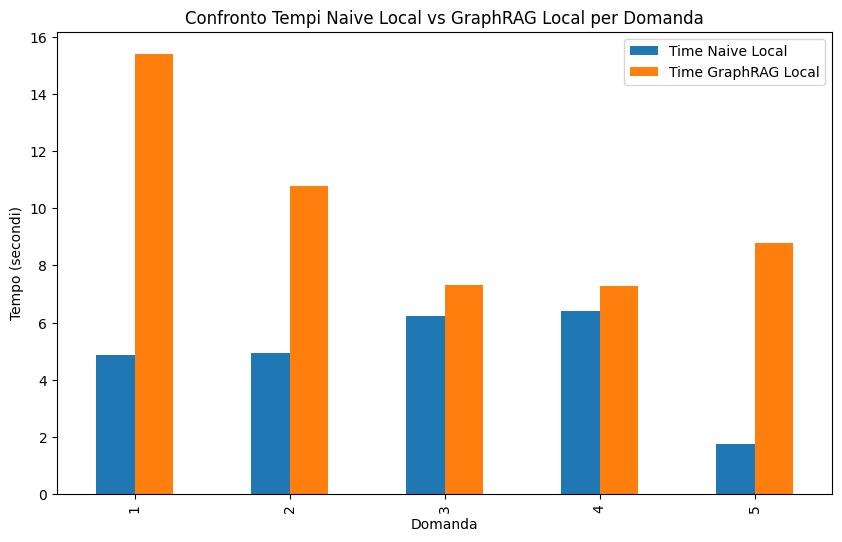

In [129]:
df_local.plot(x='Domanda', y=['Time Naive Local', 'Time GraphRAG Local'], kind='bar', figsize=(10, 6))
plt.title('Confronto Tempi Naive Local vs GraphRAG Local per Domanda')
plt.ylabel('Tempo (secondi)')
plt.show()

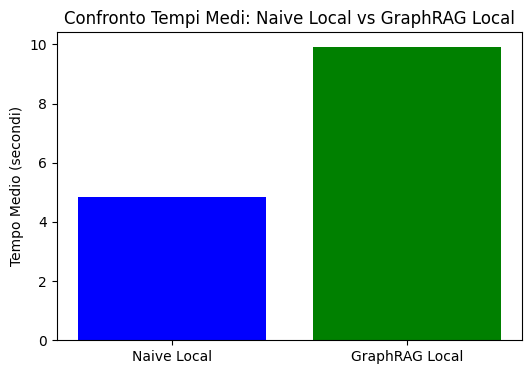

In [130]:
plt.figure(figsize=(6, 4))
plt.bar(['Naive Local', 'GraphRAG Local'], [mean_naive_local, mean_graph_local], color=['blue', 'green'])
plt.title('Confronto Tempi Medi: Naive Local vs GraphRAG Local')
plt.ylabel('Tempo Medio (secondi)')
plt.show()

## 3. Approfondimento query GraphRAG